In [1]:
from NoisyCircuits import QuantumCircuit as QC
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json
np.random.seed(24)

2026-01-15 19:10:14,690	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
token = json.load(open(os.path.join(os.path.expanduser("~"), "ibm_api.json"), "r"))["apikey"] # Replace with your IBM Quantum token
backend_name = "ibm_fez"
qpu_type = "heron"
verbose = False

In [3]:
if qpu_type == "heron":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb"))
elif qpu_type == "eagle":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Eagle_QPU.pkl", "rb"))
else:
    raise ValueError("Unsupported QPU type. Supported types are 'heron' and 'eagle'.")

In [4]:
def build_random_circuit(circuit, depth, num_qubits):
    circuit.refresh()
    gate = {
        "X" : circuit.X,
        "SX": circuit.SX,
    }
    for _ in range(depth):
        for i in range(num_qubits):
            choice = np.random.choice(["X", "SX"])
            gate[choice](i)
    for i in range(num_qubits-1):
        circuit.CZ(i, i+1)

In [5]:
def compute_metrics(pd_1, pd_2):
    battacharyya_coefficient = np.sum(np.sqrt(pd_1 * pd_2))
    battacharyya_distance = -np.log(battacharyya_coefficient)
    hellinger_distance = np.sqrt(np.sum((np.sqrt(pd_1) - np.sqrt(pd_2))**2)) / np.sqrt(2)
    m = 0.5 * (pd_1 + pd_2)
    js = 0.5 * np.sum(pd_1 * np.log(1e-10 + pd_1 / m) + pd_2 * np.log(1e-10 + pd_2 / m))
    return (battacharyya_coefficient, battacharyya_distance, hellinger_distance, js)

In [6]:
qubit_list = [2, 3, 4]
depth_list = [5, 20]
logger_qiskit = open("Qiskit_Log.log", "w")
logger_qulacs = open("Qulacs_Log.log", "w")
logger_pennylane = open("Pennylane_Log.log", "w")

In [7]:
def run_pennylane(circuit, depth, logger):
    dm = circuit.run_with_density_matrix(list(range(circuit.num_qubits)))
    mcwf_10 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=10)
    mcwf_100 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=100)
    mcwf_200 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=200)
    mcwf_500 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=500)
    mcwf_1000 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=1000)
    metrics_10 = compute_metrics(dm, mcwf_10)
    metrics_100 = compute_metrics(dm, mcwf_100)
    metrics_200 = compute_metrics(dm, mcwf_200)
    metrics_500 = compute_metrics(dm, mcwf_500)
    metrics_1000 = compute_metrics(dm, mcwf_1000)
    logger.write(f"Metrics for {circuit.num_qubits} Qubits with depth of {depth}\n")
    for traj, metric in zip([10, 100, 200, 500, 1000], [metrics_10, metrics_100, metrics_200, metrics_500, metrics_1000]):
        logger.write("No. of Trajectories: {}\n".format(traj))
        logger.write("Battacharyya Coefficient:\t{}\n".format(metric[0]))
        logger.write("Battacharyya Distance:\t{}\n".format(metric[1]))
        logger.write("Hellinger Distance:\t{}\n".format(metric[2]))
        logger.write("Jenson-Shannon Divergence:\t{}\n".format(metric[3]))     
    logger.write("===========================================================================\n\n")
    logger.flush()
    return (metrics_10, metrics_100, metrics_200, metrics_500, metrics_1000)

In [8]:
def run_qiskit(circuit, depth, logger):
    dm = circuit.run_with_density_matrix(list(range(circuit.num_qubits)))
    mcwf_10 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=10)
    mcwf_100 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=100)
    mcwf_200 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=200)
    mcwf_500 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=500)
    mcwf_1000 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=1000)
    metrics_10 = compute_metrics(dm, mcwf_10)
    metrics_100 = compute_metrics(dm, mcwf_100)
    metrics_200 = compute_metrics(dm, mcwf_200)
    metrics_500 = compute_metrics(dm, mcwf_500)
    metrics_1000 = compute_metrics(dm, mcwf_1000)
    logger.write(f"Metrics for {circuit.num_qubits} Qubits with depth of {depth}\n")
    for traj, metric in zip([10, 100, 200, 500, 1000], [metrics_10, metrics_100, metrics_200, metrics_500, metrics_1000]):
        logger.write("No. of Trajectories: {}\n".format(traj))
        logger.write("Battacharyya Coefficient:\t{}\n".format(metric[0]))
        logger.write("Battacharyya Distance:\t{}\n".format(metric[1]))
        logger.write("Hellinger Distance:\t{}\n".format(metric[2]))
        logger.write("Jenson-Shannon Divergence:\t{}\n".format(metric[3]))     
    logger.write("===========================================================================\n\n")
    logger.flush()
    return (metrics_10, metrics_100, metrics_200, metrics_500, metrics_1000)

In [9]:
def run_qulacs(circuit, depth, logger):
    dm = circuit.run_with_density_matrix(list(range(circuit.num_qubits)))
    mcwf_10 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=10)
    mcwf_100 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=100)
    mcwf_200 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=200)
    mcwf_500 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=500)
    mcwf_1000 = circuit.execute(list(range(circuit.num_qubits)), num_trajectories=1000)
    metrics_10 = compute_metrics(dm, mcwf_10)
    metrics_100 = compute_metrics(dm, mcwf_100)
    metrics_200 = compute_metrics(dm, mcwf_200)
    metrics_500 = compute_metrics(dm, mcwf_500)
    metrics_1000 = compute_metrics(dm, mcwf_1000)
    logger.write(f"Metrics for {circuit.num_qubits} Qubits with depth of {depth}\n")
    for traj, metric in zip([10, 100, 200, 500, 1000], [metrics_10, metrics_100, metrics_200, metrics_500, metrics_1000]):
        logger.write("No. of Trajectories: {}\n".format(traj))
        logger.write("Battacharyya Coefficient:\t{}\n".format(metric[0]))
        logger.write("Battacharyya Distance:\t{}\n".format(metric[1]))
        logger.write("Hellinger Distance:\t{}\n".format(metric[2]))
        logger.write("Jenson-Shannon Divergence:\t{}\n".format(metric[3]))     
    logger.write("===========================================================================\n\n")
    logger.flush()
    return (metrics_10, metrics_100, metrics_200, metrics_500, metrics_1000)

In [10]:
output_dict = {
    "pennylane" : {},
    "qiskit" : {},
    "qulacs" : {}
}
for qubit in qubit_list:
    circ_pen = QC(num_qubits=qubit,
              noise_model=noise_model,
              backend_qpu_type=qpu_type,
              num_trajectories=1,
              num_cores=25,
              sim_backend="pennylane",
              jsonize=True,
              verbose=verbose,
              threshold=1e-8)
    circ_qis = QC(num_qubits=qubit,
              noise_model=noise_model,
              backend_qpu_type=qpu_type,
              num_trajectories=1,
              num_cores=25,
              sim_backend="qiskit",
              jsonize=True,
              verbose=verbose,
              threshold=1e-8)
    circ_qul = QC(num_qubits=qubit,
              noise_model=noise_model,
              backend_qpu_type=qpu_type,
              num_trajectories=1,
              num_cores=25,
              sim_backend="qulacs",
              jsonize=True,
              verbose=verbose,
              threshold=1e-8)
    output_dict["pennylane"][qubit] = {}
    output_dict["qiskit"][qubit] = {}
    output_dict["qulacs"][qubit] = {}
    for depth in depth_list:
        build_random_circuit(circ_pen, depth, qubit)
        instructions = circ_pen.instruction_list
        metrics_pennylane = run_pennylane(circ_pen, depth, logger_pennylane)
        circ_qis.refresh()
        circ_qis.instruction_list = instructions
        metrics_qiskit = run_qiskit(circ_qis, depth, logger_qiskit)
        circ_qul.refresh()
        circ_qul.instruction_list = instructions
        metrics_qulacs = run_qulacs(circ_qul, depth, logger_qulacs)
        output_dict["pennylane"][qubit][depth] = metrics_pennylane
        output_dict["qiskit"][qubit][depth] = metrics_qiskit
        output_dict["qulacs"][qubit][depth] = metrics_qulacs
    circ_pen.shutdown()
    circ_qis.shutdown()
    circ_qul.shutdown()

Successfully switched backend to pennylane.


2026-01-15 19:10:24,965	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 19:10:26,447	INFO worker.py:1765 -- Calling ray.init() again after it has already been called.


Successfully switched backend to qulacs.


2026-01-15 19:10:27,587	INFO worker.py:1765 -- Calling ray.init() again after it has already been called.


Successfully switched backend to pennylane.


2026-01-15 19:11:16,182	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 19:11:18,118	INFO worker.py:1765 -- Calling ray.init() again after it has already been called.


Successfully switched backend to qulacs.


2026-01-15 19:11:19,524	INFO worker.py:1765 -- Calling ray.init() again after it has already been called.


Successfully switched backend to pennylane.


2026-01-15 19:12:22,384	INFO worker.py:1927 -- Started a local Ray instance.


Successfully switched backend to qiskit.


2026-01-15 19:12:24,498	INFO worker.py:1765 -- Calling ray.init() again after it has already been called.


Successfully switched backend to qulacs.


2026-01-15 19:12:26,066	INFO worker.py:1765 -- Calling ray.init() again after it has already been called.


In [12]:
# with open("Solver_Comparison.pkl", "wb") as f:
#     pickle.dump(output_dict, f)
logger_qulacs.close()
logger_pennylane.close()
logger_qiskit.close()

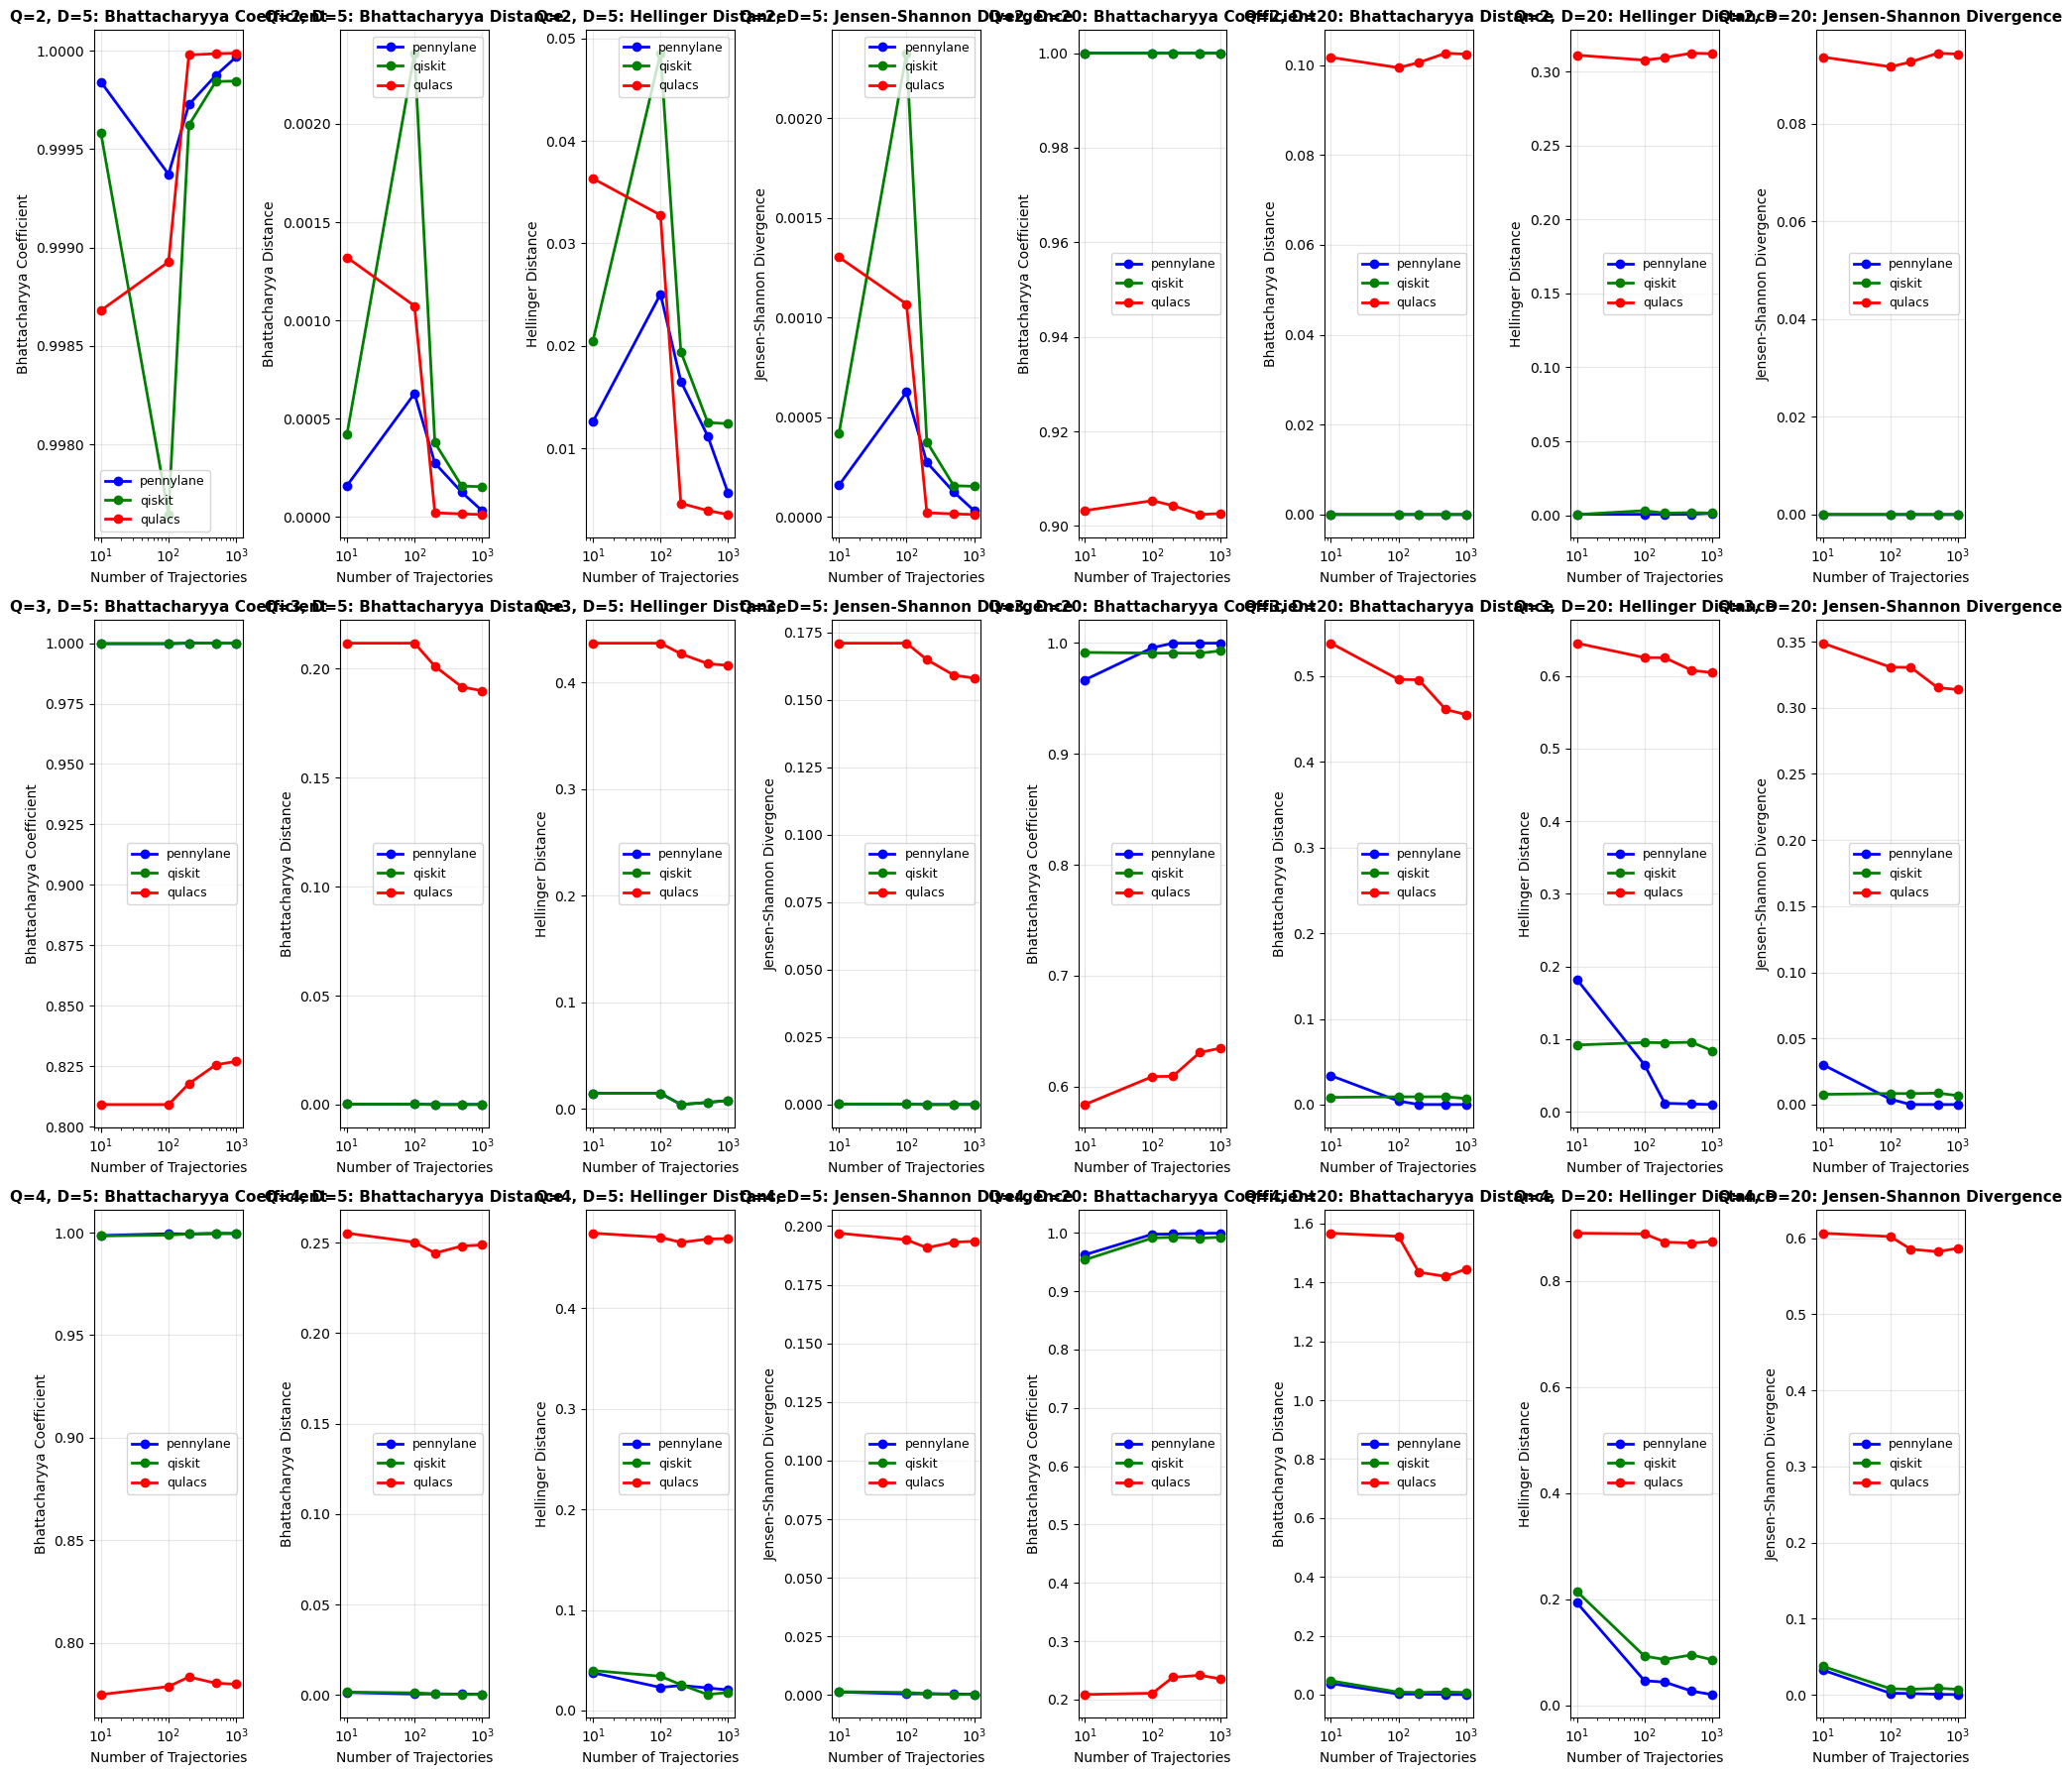

Comprehensive visualization saved as 'solver_comparison_comprehensive.png'


In [13]:
# Visualization of results
import matplotlib.pyplot as plt
import numpy as np

# Define trajectories and metric names
trajectories = [10, 100, 200, 500, 1000]
metric_names = ["Bhattacharyya Coefficient", "Bhattacharyya Distance", 
                "Hellinger Distance", "Jensen-Shannon Divergence"]
solvers = ["pennylane", "qiskit", "qulacs"]
colors = {"pennylane": "blue", "qiskit": "green", "qulacs": "red"}

# Create a comprehensive visualization
fig, axes = plt.subplots(len(qubit_list), len(depth_list) * len(metric_names), 
                         figsize=(20, 6 * len(qubit_list)))

if len(qubit_list) == 1:
    axes = axes.reshape(1, -1)

for q_idx, qubit in enumerate(qubit_list):
    for d_idx, depth in enumerate(depth_list):
        for m_idx, metric_name in enumerate(metric_names):
            ax_idx = d_idx * len(metric_names) + m_idx
            ax = axes[q_idx, ax_idx]
            
            # Plot each solver
            for solver in solvers:
                if qubit in output_dict[solver] and depth in output_dict[solver][qubit]:
                    metrics = output_dict[solver][qubit][depth]
                    metric_values = [metrics[i][m_idx] for i in range(len(trajectories))]
                    ax.plot(trajectories, metric_values, marker='o', label=solver, 
                           color=colors[solver], linewidth=2, markersize=6)
            
            ax.set_xlabel("Number of Trajectories", fontsize=10)
            ax.set_ylabel(metric_name, fontsize=10)
            ax.set_title(f"Q={qubit}, D={depth}: {metric_name}", fontsize=11, fontweight='bold')
            ax.set_xscale('log')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig("solver_comparison_comprehensive.png", dpi=300, bbox_inches='tight')
plt.show()

print("Comprehensive visualization saved as 'solver_comparison_comprehensive.png'")

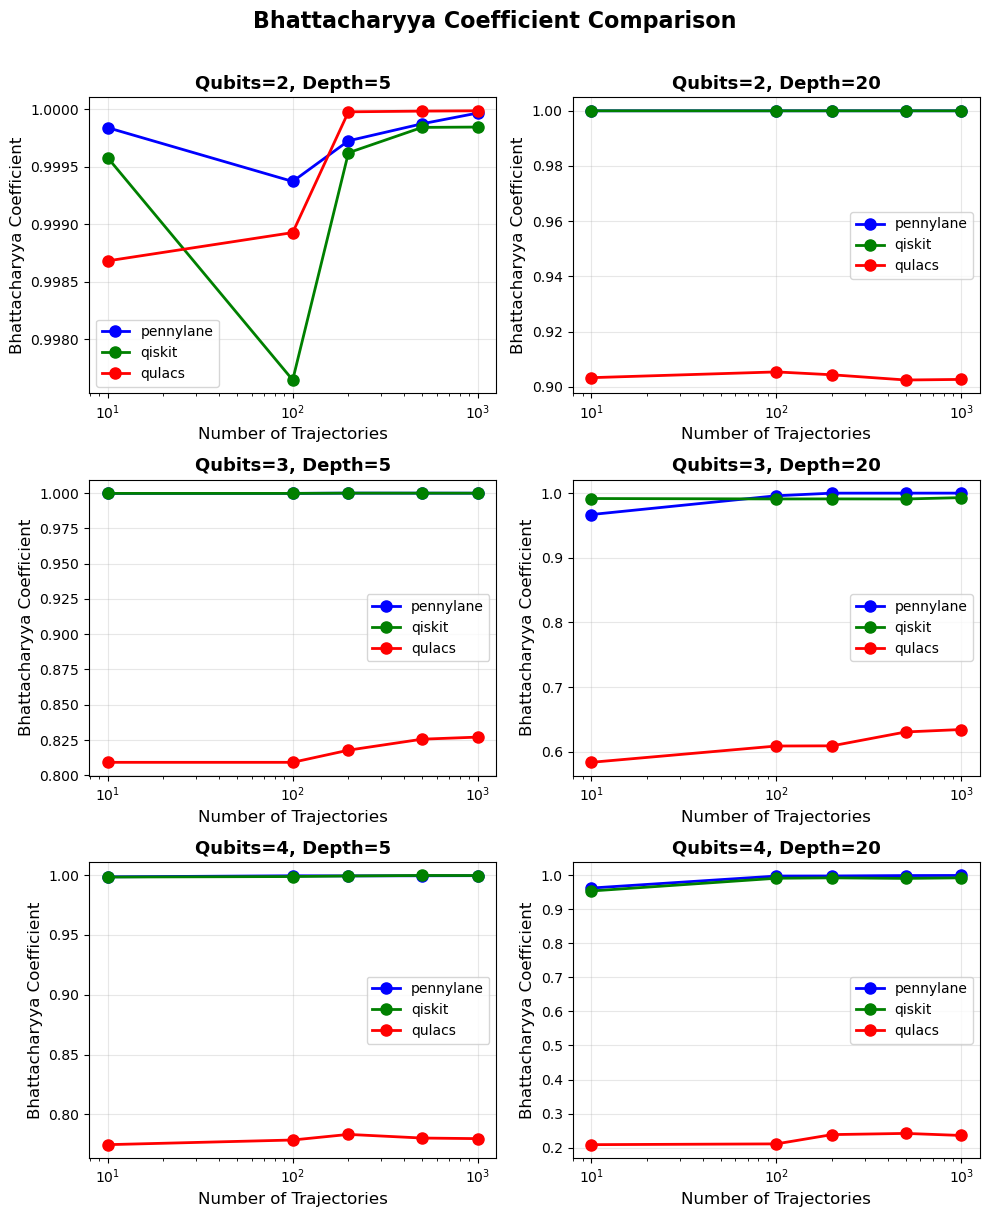

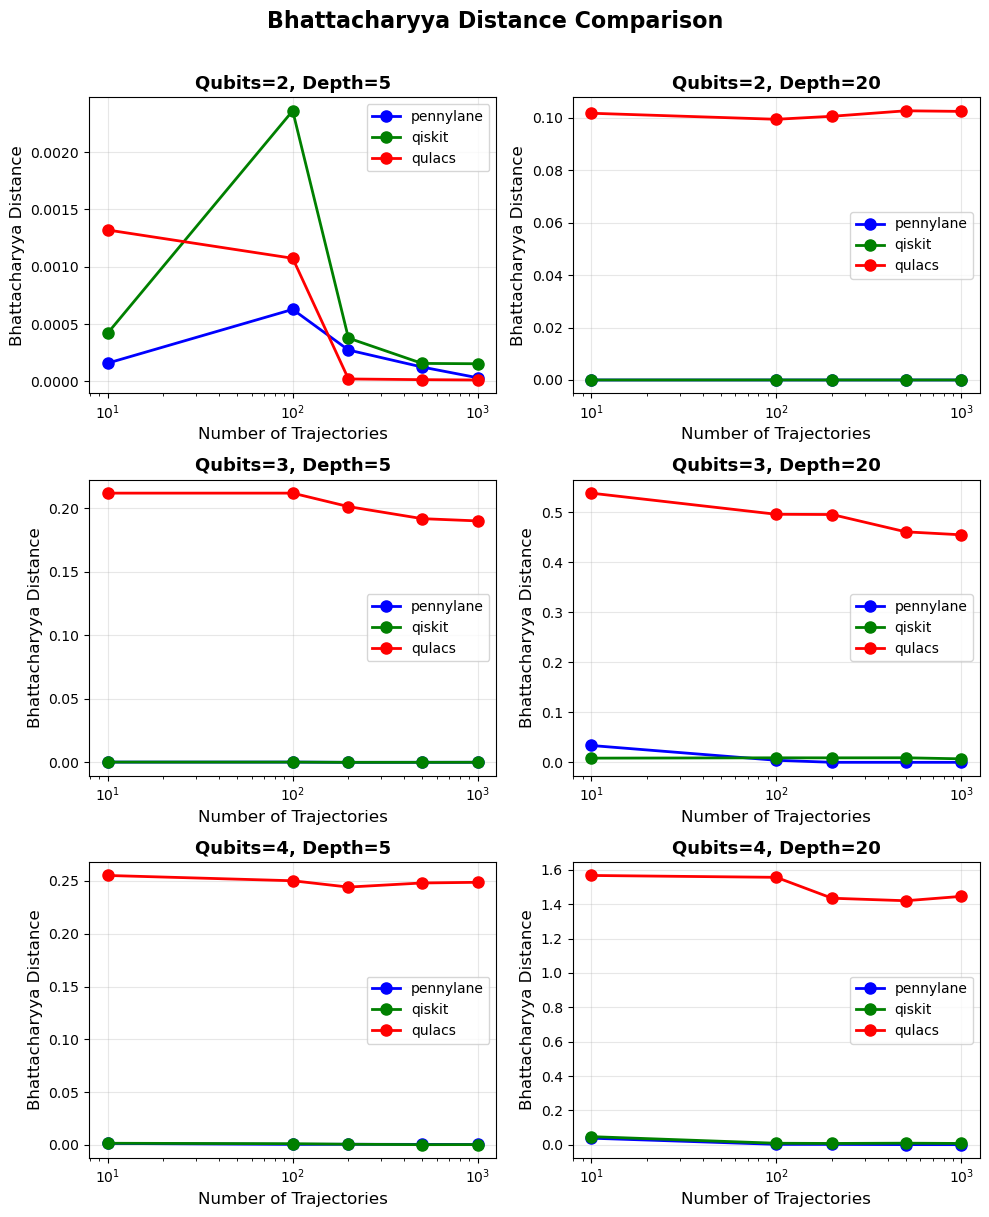

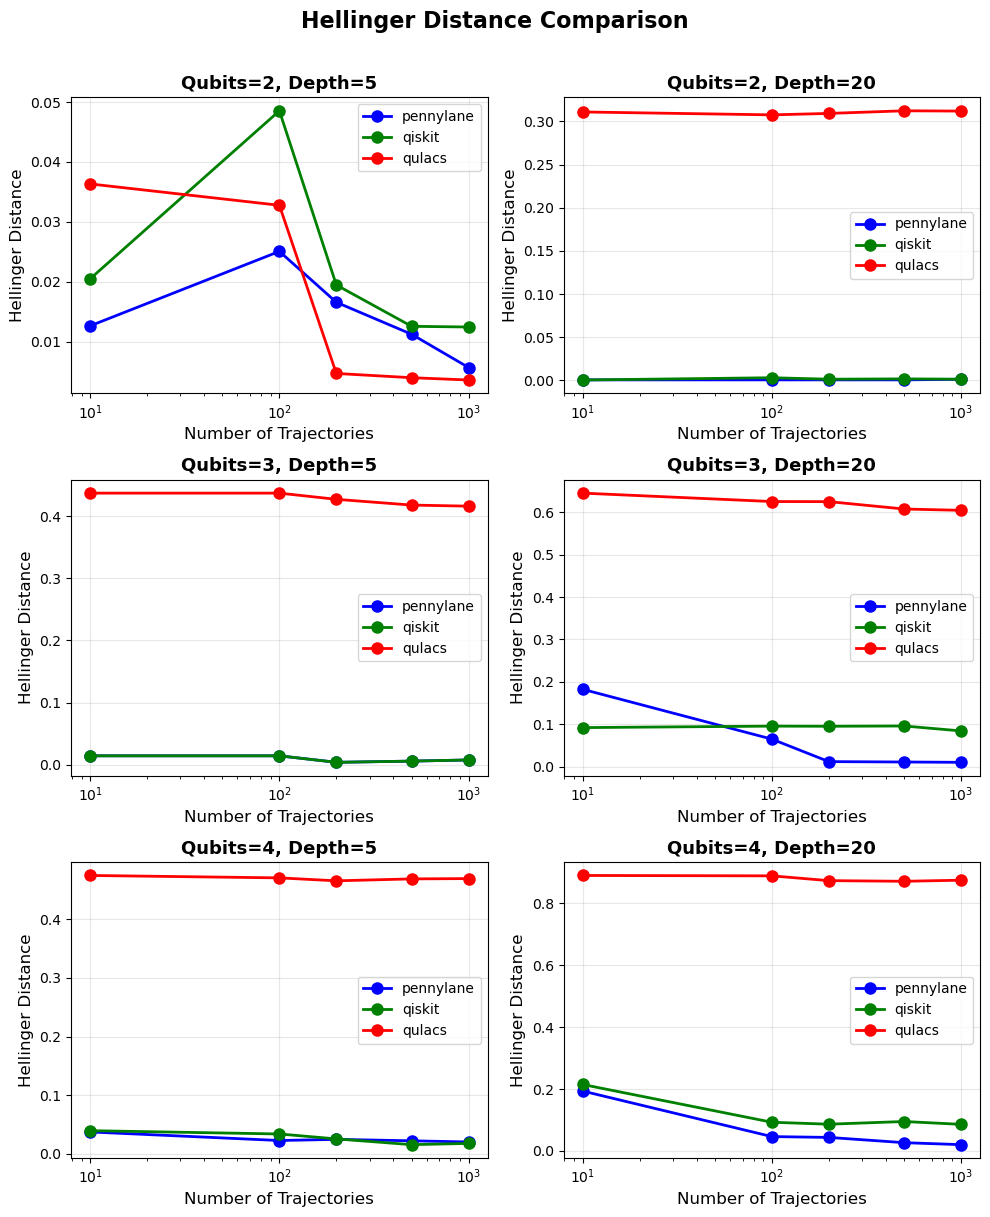

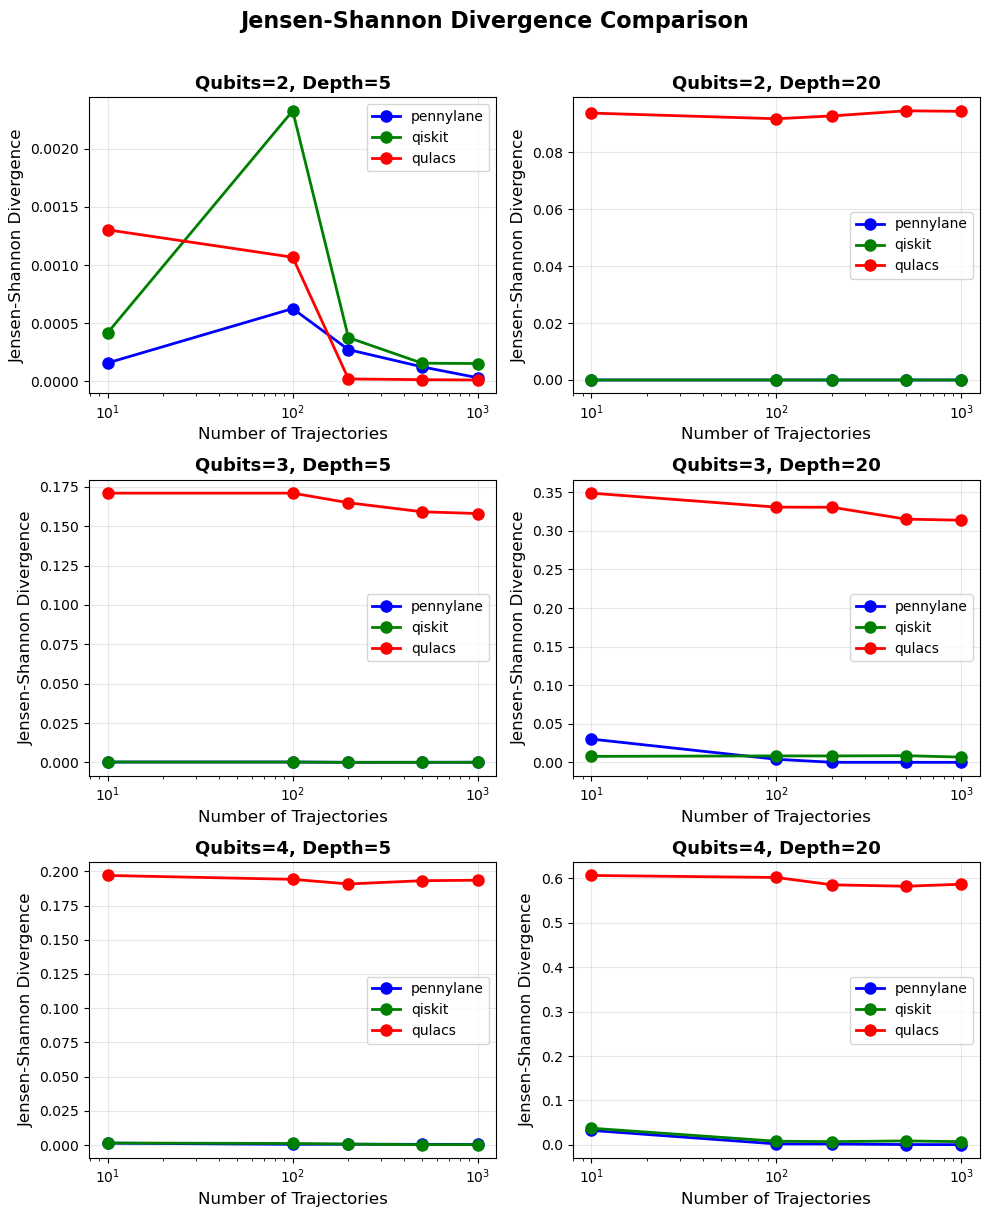

Individual metric visualizations saved!


In [14]:
# Alternative view: Separate plots by metric type
for metric_idx, metric_name in enumerate(metric_names):
    fig, axes = plt.subplots(len(qubit_list), len(depth_list), 
                             figsize=(10, 4 * len(qubit_list)))
    
    if len(qubit_list) == 1 and len(depth_list) == 1:
        axes = np.array([[axes]])
    elif len(qubit_list) == 1:
        axes = axes.reshape(1, -1)
    elif len(depth_list) == 1:
        axes = axes.reshape(-1, 1)
    
    for q_idx, qubit in enumerate(qubit_list):
        for d_idx, depth in enumerate(depth_list):
            ax = axes[q_idx, d_idx]
            
            for solver in solvers:
                if qubit in output_dict[solver] and depth in output_dict[solver][qubit]:
                    metrics = output_dict[solver][qubit][depth]
                    metric_values = [metrics[i][metric_idx] for i in range(len(trajectories))]
                    ax.plot(trajectories, metric_values, marker='o', label=solver, 
                           color=colors[solver], linewidth=2, markersize=8)
            
            ax.set_xlabel("Number of Trajectories", fontsize=12)
            ax.set_ylabel(metric_name, fontsize=12)
            ax.set_title(f"Qubits={qubit}, Depth={depth}", fontsize=13, fontweight='bold')
            ax.set_xscale('log')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
    
    plt.suptitle(f"{metric_name} Comparison", fontsize=16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(f"solver_comparison_{metric_name.replace(' ', '_').lower()}.png", 
                dpi=300, bbox_inches='tight')
    plt.show()

print("Individual metric visualizations saved!")